In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [11]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Ariel']
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '25'
mpl.rcParams['ytick.labelsize'] = '25'

In [3]:
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
import astropy.constants as c

In [4]:
import pandas as pd
from astropy.io import fits
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning

## H$\alpha$ flux for 18byg host

In [5]:
z = 0.06633826
ebv = 0.008
spec = fits.open('18byg_sdss_spec.fits')
data = spec[1].data

wv = 10**data['loglam']
fl = data['flux']  # * 1e-17 in cgs
fl_unc = data['ivar']**-.5

Av = calALambda(wv, 3.1, ebv)

fl_jy = (fl * 1e-17 * u.erg / u.s / u.cm**2 / u.AA).to(
    'Jy', u.spectral_density(wv * u.AA)) * 10**(0.4 * Av)
fl_unc_jy = (fl_unc * 1e-17 * u.erg / u.s / u.cm**2 / u.AA).to(
    'Jy', u.spectral_density(wv * u.AA)) * 10**(0.4 * Av)

In [6]:
# sloan
# effective wavelength
g_lref = 4702.50  # * u.AA
r_lref = 6175.58  # * u.AA
z_lref = 8946.71  # * u.AA

# effective width
g_w = 1064.68
r_w = 1055.51
z_w = 1164.01

# Legacy
LS_wv = np.array([g_lref, r_lref, z_lref])
LS_w = np.array([g_w, r_w, z_w])

In [7]:
ls_mag = np.array(
    [16.133438, 15.205797, 14.563972])
ls_mag_unc = np.array([
    1.41691785e-03, 9.66420738e-04, 5.55811186e-04
])

ls_fl = 3631 * 10**(-0.4 * ls_mag)
ls_fl_unc = (10**(0.4 * ls_mag_unc) - 10**(-0.4 * ls_mag_unc)) / 2 * ls_fl
print(ls_fl / ls_fl_unc)
for b in range(3):
    print('{:.5f} {:.5f}'.format(ls_mag[b], ls_mag_unc[b]))

[ 766.26594589 1123.46105448 1953.42624381]
16.13344 0.00142
15.20580 0.00097
14.56397 0.00056


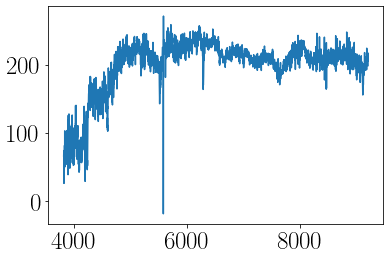

In [8]:
norm = pd.read_csv('SN2018byg_norm_factor.csv')
fl_norm = (fl_jy / np.array(norm['norm']) * 3631).to(
    'erg s**-1 cm**-2 AA**-1', u.spectral_density(wv * u.AA))
fl_unc_norm = (fl_unc_jy / np.array(norm['norm']) * 3631).to(
    'erg s**-1 cm**-2 AA**-1', u.spectral_density(wv * u.AA))
plt.plot(wv, fl_norm * 1e17)

6998.165799066261
3505.78687162213 11.29648912288211
15.038101846376037 0.0034985154903254467


Text(0, 0.5, '$\\mathrm{Flux}\\ [\\mu\\mathrm{Jy}]$')

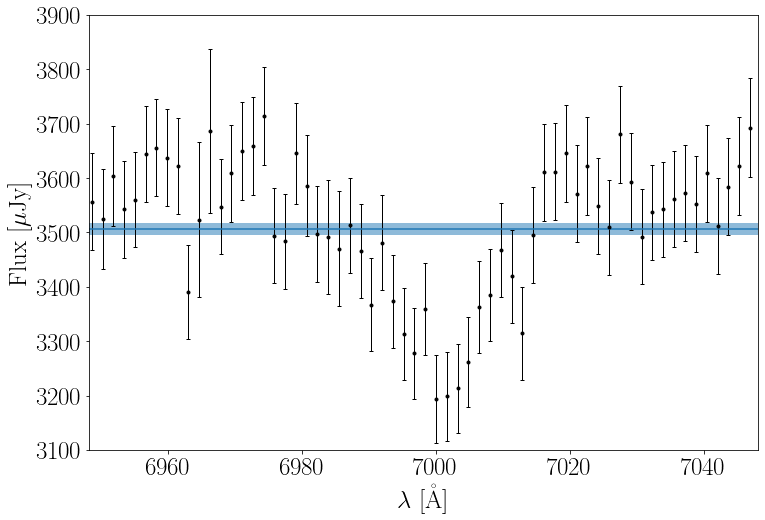

In [12]:
#show the Halpha features
width = 100
plt.figure(figsize=(12, 8))
plt.errorbar(wv,
             fl_jy / np.array(norm['norm']) * 3631e6,
             fl_unc_jy / np.array(norm['norm']) * 3631e6,
             color='k',
             linewidth=1,
             fmt='.',
             capsize=2)
Halpha = 6562.801 * (1 + z)
print(Halpha)
plt.xlim(Halpha - width / 2, Halpha + width / 2)
plt.ylim(3100, 3900)

arg = np.argwhere((Halpha - width / 2 < wv)
                  & (Halpha + width / 2 > wv)).ravel()
Halpha_fl_norm = (fl_norm[arg] / fl_unc_norm[arg]**2).sum() / (1 / fl_unc_norm[arg]**2).sum()
Halpha_fl_unc_norm = (1 / fl_unc_norm[arg]**2).sum()**-.5
Halpha_fl_norm_jy = (Halpha_fl_norm).to(
    'Jy', u.spectral_density(Halpha * u.AA))
Halpha_fl_unc_norm_jy = (Halpha_fl_unc_norm).to(
    'Jy', u.spectral_density(Halpha * u.AA))
print(Halpha_fl_norm_jy.value*1e6, Halpha_fl_unc_norm_jy.value*1e6)
print(
    -2.5 * np.log10(Halpha_fl_norm_jy.value / 3631), -2.5 / 2 * np.log10(
        (Halpha_fl_norm_jy - Halpha_fl_unc_norm_jy) / (Halpha_fl_norm_jy + Halpha_fl_unc_norm_jy)))

plt.fill_between([Halpha - width / 2, Halpha + width / 2],
                 y1=[(Halpha_fl_norm_jy - Halpha_fl_unc_norm_jy).value * 1e6] * 2,
                 y2=[(Halpha_fl_norm_jy + Halpha_fl_unc_norm_jy).value * 1e6] * 2,
                 alpha=0.5)
plt.axhline(Halpha_fl_norm_jy.value * 1e6)
plt.xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
plt.ylabel(r'$\mathrm{Flux}\ [\mu\mathrm{Jy}]$')

Text(0, 0.5, '$\\mathrm{Flux}\\ [\\mu\\mathrm{Jy}]$')

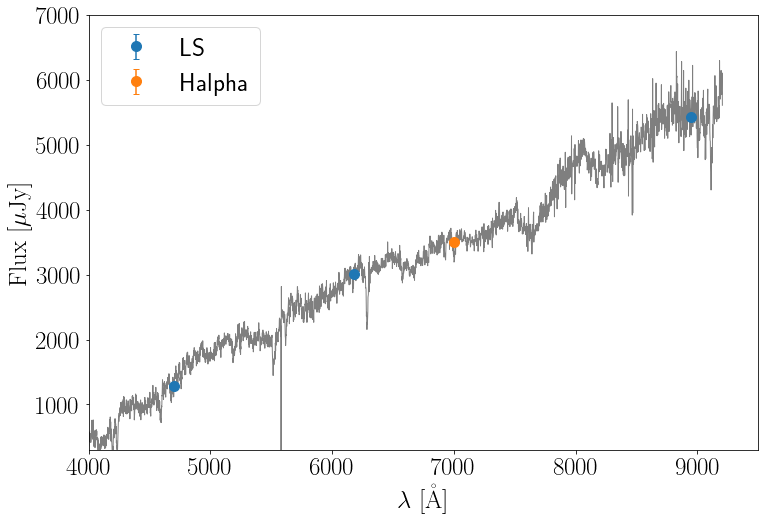

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(wv, fl_jy / np.array(norm['norm']) * 3631e6, color='k', linewidth=1, alpha=0.5)
plt.errorbar(LS_wv,
             ls_fl * 1e6,
             yerr=ls_fl_unc * 1e6,
             fmt='o',
             capsize=3,
             label='LS', markersize=10)
plt.errorbar(Halpha,
             Halpha_fl_norm_jy * 1e6,
             yerr=Halpha_fl_unc_norm_jy * 1e6,
             fmt='o',
             capsize=3, markersize=10, label='Halpha')
#plt.errorbar(MASS_wv,
#             mass_fl * 1e6,
#             yerr=mass_fl_unc * 1e6,
#             fmt='o',
#             capsize=3)
#plt.errorbar(WISE_wv,
#             WISE_fl * 1e6,
#             yerr=WISE_fl_unc * 1e6,
#             fmt='o',
#             capsize=3)
plt.ylim(3e2, 7e3)
#plt.legend()
#plt.xscale('log')
plt.xlim(4000, 9500)
#plt.yscale('log')
plt.legend()
plt.xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
plt.ylabel(r'$\mathrm{Flux}\ [\mu\mathrm{Jy}]$')